# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
display(probs)
linear_classifer.cross_entropy_loss(probs, 1)

array([4.50940412e-05, 6.69254912e-03, 9.93262357e-01])

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.609816
Epoch 1, loss: 2.609771
Epoch 2, loss: 2.609726
Epoch 3, loss: 2.609682
Epoch 4, loss: 2.609639
Epoch 5, loss: 2.609597
Epoch 6, loss: 2.609556
Epoch 7, loss: 2.609516
Epoch 8, loss: 2.609476
Epoch 9, loss: 2.609438


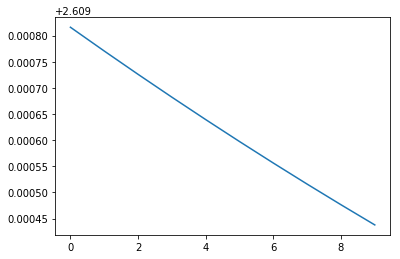

In [12]:
# let's look at the loss history!
plt.plot(loss_history)

In [14]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.09399999999999997
Epoch 0, loss: 2.609400
Epoch 1, loss: 2.609363
Epoch 2, loss: 2.609327
Epoch 3, loss: 2.609292
Epoch 4, loss: 2.609257
Epoch 5, loss: 2.609224
Epoch 6, loss: 2.609191
Epoch 7, loss: 2.609159
Epoch 8, loss: 2.609128
Epoch 9, loss: 2.609097
Epoch 10, loss: 2.609068
Epoch 11, loss: 2.609039
Epoch 12, loss: 2.609011
Epoch 13, loss: 2.608983
Epoch 14, loss: 2.608957
Epoch 15, loss: 2.608931
Epoch 16, loss: 2.608906
Epoch 17, loss: 2.608882
Epoch 18, loss: 2.608859
Epoch 19, loss: 2.608836
Epoch 20, loss: 2.608814
Epoch 21, loss: 2.608793
Epoch 22, loss: 2.608773
Epoch 23, loss: 2.608753
Epoch 24, loss: 2.608735
Epoch 25, loss: 2.608717
Epoch 26, loss: 2.608699
Epoch 27, loss: 2.608683
Epoch 28, loss: 2.608667
Epoch 29, loss: 2.608652
Epoch 30, loss: 2.608637
Epoch 31, loss: 2.608624
Epoch 32, loss: 2.608611
Epoch 33, loss: 2.608599
Epoch 34, loss: 2.608587
Epoch 35, loss: 2.608577
Epoch 36, loss: 2.608567
Epoch 37, loss: 2.608557
Epoch 38, loss: 2.608549
Epoc

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [16]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [1e-3, 1e-2, 1e-4, 1e-5, 1e-6, 1e-7]
best_val_accuracy = 0
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier.fit(train_X, train_y, batch_size, learning_rate, reg_strength, num_epochs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print('Accuracy %f reg_strength %f learning rate %f' % (accuracy, reg_strength, learning_rate))
        print('Accuracy %f reg_strength %f learning rate %f' % (accuracy, reg_strength, learning_rate), file=open("accuracy.txt", "a"))
        best_val_accuracy = max(best_val_accuracy, accuracy)
        
best_classifier = None
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.299253
Epoch 1, loss: 2.296205
Epoch 2, loss: 2.293332
Epoch 3, loss: 2.290550
Epoch 4, loss: 2.287845
Epoch 5, loss: 2.285214
Epoch 6, loss: 2.282651
Epoch 7, loss: 2.280155
Epoch 8, loss: 2.277721
Epoch 9, loss: 2.275346
Epoch 10, loss: 2.273029
Epoch 11, loss: 2.270765
Epoch 12, loss: 2.268554
Epoch 13, loss: 2.266393
Epoch 14, loss: 2.264280
Epoch 15, loss: 2.262214
Epoch 16, loss: 2.260192
Epoch 17, loss: 2.258214
Epoch 18, loss: 2.256277
Epoch 19, loss: 2.254381
Epoch 20, loss: 2.252524
Epoch 21, loss: 2.250705
Epoch 22, loss: 2.248923
Epoch 23, loss: 2.247177
Epoch 24, loss: 2.245466
Epoch 25, loss: 2.243788
Epoch 26, loss: 2.242144
Epoch 27, loss: 2.240532
Epoch 28, loss: 2.238952
Epoch 29, loss: 2.237402
Epoch 30, loss: 2.235882
Epoch 31, loss: 2.234391
Epoch 32, loss: 2.232929
Epoch 33, loss: 2.231495
Epoch 34, loss: 2.230087
Epoch 35, loss: 2.228706
Epoch 36, loss: 2.227352
Epoch 37, loss: 2.226022
Epoch 38, loss: 2.224717
Epoch 39, loss: 2.223437
Epoch 40, 

Epoch 123, loss: 2.163550
Epoch 124, loss: 2.163543
Epoch 125, loss: 2.163537
Epoch 126, loss: 2.163532
Epoch 127, loss: 2.163526
Epoch 128, loss: 2.163521
Epoch 129, loss: 2.163516
Epoch 130, loss: 2.163512
Epoch 131, loss: 2.163508
Epoch 132, loss: 2.163505
Epoch 133, loss: 2.163501
Epoch 134, loss: 2.163498
Epoch 135, loss: 2.163496
Epoch 136, loss: 2.163494
Epoch 137, loss: 2.163492
Epoch 138, loss: 2.163490
Epoch 139, loss: 2.163489
Epoch 140, loss: 2.163488
Epoch 141, loss: 2.163487
Epoch 142, loss: 2.163487
Epoch 143, loss: 2.163487
Epoch 144, loss: 2.163487
Epoch 145, loss: 2.163488
Epoch 146, loss: 2.163489
Epoch 147, loss: 2.163491
Epoch 148, loss: 2.163492
Epoch 149, loss: 2.163494
Epoch 150, loss: 2.163497
Epoch 151, loss: 2.163499
Epoch 152, loss: 2.163502
Epoch 153, loss: 2.163505
Epoch 154, loss: 2.163509
Epoch 155, loss: 2.163513
Epoch 156, loss: 2.163517
Epoch 157, loss: 2.163521
Epoch 158, loss: 2.163526
Epoch 159, loss: 2.163531
Epoch 160, loss: 2.163536
Epoch 161, l

Epoch 41, loss: 2.095922
Epoch 42, loss: 2.095861
Epoch 43, loss: 2.095800
Epoch 44, loss: 2.095739
Epoch 45, loss: 2.095678
Epoch 46, loss: 2.095617
Epoch 47, loss: 2.095557
Epoch 48, loss: 2.095496
Epoch 49, loss: 2.095436
Epoch 50, loss: 2.095375
Epoch 51, loss: 2.095315
Epoch 52, loss: 2.095255
Epoch 53, loss: 2.095195
Epoch 54, loss: 2.095135
Epoch 55, loss: 2.095075
Epoch 56, loss: 2.095015
Epoch 57, loss: 2.094955
Epoch 58, loss: 2.094896
Epoch 59, loss: 2.094836
Epoch 60, loss: 2.094777
Epoch 61, loss: 2.094717
Epoch 62, loss: 2.094658
Epoch 63, loss: 2.094599
Epoch 64, loss: 2.094540
Epoch 65, loss: 2.094481
Epoch 66, loss: 2.094422
Epoch 67, loss: 2.094363
Epoch 68, loss: 2.094304
Epoch 69, loss: 2.094245
Epoch 70, loss: 2.094187
Epoch 71, loss: 2.094128
Epoch 72, loss: 2.094070
Epoch 73, loss: 2.094012
Epoch 74, loss: 2.093953
Epoch 75, loss: 2.093895
Epoch 76, loss: 2.093837
Epoch 77, loss: 2.093779
Epoch 78, loss: 2.093721
Epoch 79, loss: 2.093663
Epoch 80, loss: 2.093605


Epoch 161, loss: 2.079814
Epoch 162, loss: 2.079772
Epoch 163, loss: 2.079730
Epoch 164, loss: 2.079688
Epoch 165, loss: 2.079647
Epoch 166, loss: 2.079605
Epoch 167, loss: 2.079564
Epoch 168, loss: 2.079522
Epoch 169, loss: 2.079480
Epoch 170, loss: 2.079439
Epoch 171, loss: 2.079398
Epoch 172, loss: 2.079356
Epoch 173, loss: 2.079315
Epoch 174, loss: 2.079273
Epoch 175, loss: 2.079232
Epoch 176, loss: 2.079191
Epoch 177, loss: 2.079150
Epoch 178, loss: 2.079109
Epoch 179, loss: 2.079067
Epoch 180, loss: 2.079026
Epoch 181, loss: 2.078985
Epoch 182, loss: 2.078944
Epoch 183, loss: 2.078903
Epoch 184, loss: 2.078862
Epoch 185, loss: 2.078821
Epoch 186, loss: 2.078780
Epoch 187, loss: 2.078740
Epoch 188, loss: 2.078699
Epoch 189, loss: 2.078658
Epoch 190, loss: 2.078617
Epoch 191, loss: 2.078577
Epoch 192, loss: 2.078536
Epoch 193, loss: 2.078495
Epoch 194, loss: 2.078455
Epoch 195, loss: 2.078414
Epoch 196, loss: 2.078374
Epoch 197, loss: 2.078333
Epoch 198, loss: 2.078293
Epoch 199, l

Epoch 78, loss: 2.084502
Epoch 79, loss: 2.084499
Epoch 80, loss: 2.084497
Epoch 81, loss: 2.084495
Epoch 82, loss: 2.084492
Epoch 83, loss: 2.084490
Epoch 84, loss: 2.084488
Epoch 85, loss: 2.084485
Epoch 86, loss: 2.084483
Epoch 87, loss: 2.084481
Epoch 88, loss: 2.084479
Epoch 89, loss: 2.084476
Epoch 90, loss: 2.084474
Epoch 91, loss: 2.084472
Epoch 92, loss: 2.084469
Epoch 93, loss: 2.084467
Epoch 94, loss: 2.084465
Epoch 95, loss: 2.084463
Epoch 96, loss: 2.084460
Epoch 97, loss: 2.084458
Epoch 98, loss: 2.084456
Epoch 99, loss: 2.084453
Epoch 100, loss: 2.084451
Epoch 101, loss: 2.084449
Epoch 102, loss: 2.084446
Epoch 103, loss: 2.084444
Epoch 104, loss: 2.084442
Epoch 105, loss: 2.084440
Epoch 106, loss: 2.084437
Epoch 107, loss: 2.084435
Epoch 108, loss: 2.084433
Epoch 109, loss: 2.084430
Epoch 110, loss: 2.084428
Epoch 111, loss: 2.084426
Epoch 112, loss: 2.084424
Epoch 113, loss: 2.084421
Epoch 114, loss: 2.084419
Epoch 115, loss: 2.084417
Epoch 116, loss: 2.084414
Epoch 11

Epoch 197, loss: 2.213084
Epoch 198, loss: 2.213092
Epoch 199, loss: 2.213100
Accuracy 0.248000 reg_strength 0.010000 learning rate 0.010000
Epoch 0, loss: 2.070841
Epoch 1, loss: 2.070838
Epoch 2, loss: 2.070835
Epoch 3, loss: 2.070832
Epoch 4, loss: 2.070829
Epoch 5, loss: 2.070825
Epoch 6, loss: 2.070822
Epoch 7, loss: 2.070819
Epoch 8, loss: 2.070816
Epoch 9, loss: 2.070812
Epoch 10, loss: 2.070809
Epoch 11, loss: 2.070806
Epoch 12, loss: 2.070803
Epoch 13, loss: 2.070799
Epoch 14, loss: 2.070796
Epoch 15, loss: 2.070793
Epoch 16, loss: 2.070790
Epoch 17, loss: 2.070787
Epoch 18, loss: 2.070783
Epoch 19, loss: 2.070780
Epoch 20, loss: 2.070777
Epoch 21, loss: 2.070774
Epoch 22, loss: 2.070770
Epoch 23, loss: 2.070767
Epoch 24, loss: 2.070764
Epoch 25, loss: 2.070761
Epoch 26, loss: 2.070758
Epoch 27, loss: 2.070754
Epoch 28, loss: 2.070751
Epoch 29, loss: 2.070748
Epoch 30, loss: 2.070745
Epoch 31, loss: 2.070741
Epoch 32, loss: 2.070738
Epoch 33, loss: 2.070735
Epoch 34, loss: 2.0

Epoch 117, loss: 2.068502
Epoch 118, loss: 2.068499
Epoch 119, loss: 2.068496
Epoch 120, loss: 2.068493
Epoch 121, loss: 2.068489
Epoch 122, loss: 2.068486
Epoch 123, loss: 2.068483
Epoch 124, loss: 2.068480
Epoch 125, loss: 2.068476
Epoch 126, loss: 2.068473
Epoch 127, loss: 2.068470
Epoch 128, loss: 2.068467
Epoch 129, loss: 2.068463
Epoch 130, loss: 2.068460
Epoch 131, loss: 2.068457
Epoch 132, loss: 2.068454
Epoch 133, loss: 2.068450
Epoch 134, loss: 2.068447
Epoch 135, loss: 2.068444
Epoch 136, loss: 2.068440
Epoch 137, loss: 2.068437
Epoch 138, loss: 2.068434
Epoch 139, loss: 2.068431
Epoch 140, loss: 2.068427
Epoch 141, loss: 2.068424
Epoch 142, loss: 2.068421
Epoch 143, loss: 2.068418
Epoch 144, loss: 2.068414
Epoch 145, loss: 2.068411
Epoch 146, loss: 2.068408
Epoch 147, loss: 2.068405
Epoch 148, loss: 2.068401
Epoch 149, loss: 2.068398
Epoch 150, loss: 2.068395
Epoch 151, loss: 2.068392
Epoch 152, loss: 2.068388
Epoch 153, loss: 2.068385
Epoch 154, loss: 2.068382
Epoch 155, l

Epoch 35, loss: 2.067326
Epoch 36, loss: 2.067323
Epoch 37, loss: 2.067320
Epoch 38, loss: 2.067316
Epoch 39, loss: 2.067313
Epoch 40, loss: 2.067310
Epoch 41, loss: 2.067307
Epoch 42, loss: 2.067304
Epoch 43, loss: 2.067300
Epoch 44, loss: 2.067297
Epoch 45, loss: 2.067294
Epoch 46, loss: 2.067291
Epoch 47, loss: 2.067288
Epoch 48, loss: 2.067284
Epoch 49, loss: 2.067281
Epoch 50, loss: 2.067278
Epoch 51, loss: 2.067275
Epoch 52, loss: 2.067272
Epoch 53, loss: 2.067268
Epoch 54, loss: 2.067265
Epoch 55, loss: 2.067262
Epoch 56, loss: 2.067259
Epoch 57, loss: 2.067256
Epoch 58, loss: 2.067252
Epoch 59, loss: 2.067249
Epoch 60, loss: 2.067246
Epoch 61, loss: 2.067243
Epoch 62, loss: 2.067240
Epoch 63, loss: 2.067236
Epoch 64, loss: 2.067233
Epoch 65, loss: 2.067230
Epoch 66, loss: 2.067227
Epoch 67, loss: 2.067224
Epoch 68, loss: 2.067220
Epoch 69, loss: 2.067217
Epoch 70, loss: 2.067214
Epoch 71, loss: 2.067211
Epoch 72, loss: 2.067208
Epoch 73, loss: 2.067204
Epoch 74, loss: 2.067201


Epoch 155, loss: 2.082041
Epoch 156, loss: 2.082041
Epoch 157, loss: 2.082041
Epoch 158, loss: 2.082040
Epoch 159, loss: 2.082040
Epoch 160, loss: 2.082040
Epoch 161, loss: 2.082040
Epoch 162, loss: 2.082040
Epoch 163, loss: 2.082039
Epoch 164, loss: 2.082039
Epoch 165, loss: 2.082039
Epoch 166, loss: 2.082039
Epoch 167, loss: 2.082038
Epoch 168, loss: 2.082038
Epoch 169, loss: 2.082038
Epoch 170, loss: 2.082038
Epoch 171, loss: 2.082038
Epoch 172, loss: 2.082037
Epoch 173, loss: 2.082037
Epoch 174, loss: 2.082037
Epoch 175, loss: 2.082037
Epoch 176, loss: 2.082037
Epoch 177, loss: 2.082036
Epoch 178, loss: 2.082036
Epoch 179, loss: 2.082036
Epoch 180, loss: 2.082036
Epoch 181, loss: 2.082036
Epoch 182, loss: 2.082035
Epoch 183, loss: 2.082035
Epoch 184, loss: 2.082035
Epoch 185, loss: 2.082035
Epoch 186, loss: 2.082035
Epoch 187, loss: 2.082034
Epoch 188, loss: 2.082034
Epoch 189, loss: 2.082034
Epoch 190, loss: 2.082034
Epoch 191, loss: 2.082034
Epoch 192, loss: 2.082033
Epoch 193, l

Epoch 73, loss: 2.068181
Epoch 74, loss: 2.068181
Epoch 75, loss: 2.068180
Epoch 76, loss: 2.068180
Epoch 77, loss: 2.068180
Epoch 78, loss: 2.068179
Epoch 79, loss: 2.068179
Epoch 80, loss: 2.068179
Epoch 81, loss: 2.068179
Epoch 82, loss: 2.068178
Epoch 83, loss: 2.068178
Epoch 84, loss: 2.068178
Epoch 85, loss: 2.068177
Epoch 86, loss: 2.068177
Epoch 87, loss: 2.068177
Epoch 88, loss: 2.068176
Epoch 89, loss: 2.068176
Epoch 90, loss: 2.068176
Epoch 91, loss: 2.068176
Epoch 92, loss: 2.068175
Epoch 93, loss: 2.068175
Epoch 94, loss: 2.068175
Epoch 95, loss: 2.068174
Epoch 96, loss: 2.068174
Epoch 97, loss: 2.068174
Epoch 98, loss: 2.068173
Epoch 99, loss: 2.068173
Epoch 100, loss: 2.068173
Epoch 101, loss: 2.068172
Epoch 102, loss: 2.068172
Epoch 103, loss: 2.068172
Epoch 104, loss: 2.068172
Epoch 105, loss: 2.068171
Epoch 106, loss: 2.068171
Epoch 107, loss: 2.068171
Epoch 108, loss: 2.068170
Epoch 109, loss: 2.068170
Epoch 110, loss: 2.068170
Epoch 111, loss: 2.068169
Epoch 112, lo

Epoch 192, loss: 2.066701
Epoch 193, loss: 2.066701
Epoch 194, loss: 2.066700
Epoch 195, loss: 2.066700
Epoch 196, loss: 2.066700
Epoch 197, loss: 2.066699
Epoch 198, loss: 2.066699
Epoch 199, loss: 2.066699
Accuracy 0.250000 reg_strength 0.000010 learning rate 0.001000
Epoch 0, loss: 2.066560
Epoch 1, loss: 2.066560
Epoch 2, loss: 2.066560
Epoch 3, loss: 2.066559
Epoch 4, loss: 2.066559
Epoch 5, loss: 2.066559
Epoch 6, loss: 2.066558
Epoch 7, loss: 2.066558
Epoch 8, loss: 2.066558
Epoch 9, loss: 2.066557
Epoch 10, loss: 2.066557
Epoch 11, loss: 2.066557
Epoch 12, loss: 2.066556
Epoch 13, loss: 2.066556
Epoch 14, loss: 2.066556
Epoch 15, loss: 2.066555
Epoch 16, loss: 2.066555
Epoch 17, loss: 2.066555
Epoch 18, loss: 2.066555
Epoch 19, loss: 2.066554
Epoch 20, loss: 2.066554
Epoch 21, loss: 2.066554
Epoch 22, loss: 2.066553
Epoch 23, loss: 2.066553
Epoch 24, loss: 2.066553
Epoch 25, loss: 2.066552
Epoch 26, loss: 2.066552
Epoch 27, loss: 2.066552
Epoch 28, loss: 2.066551
Epoch 29, loss

Epoch 111, loss: 2.066448
Epoch 112, loss: 2.066448
Epoch 113, loss: 2.066448
Epoch 114, loss: 2.066447
Epoch 115, loss: 2.066447
Epoch 116, loss: 2.066447
Epoch 117, loss: 2.066446
Epoch 118, loss: 2.066446
Epoch 119, loss: 2.066446
Epoch 120, loss: 2.066445
Epoch 121, loss: 2.066445
Epoch 122, loss: 2.066445
Epoch 123, loss: 2.066444
Epoch 124, loss: 2.066444
Epoch 125, loss: 2.066444
Epoch 126, loss: 2.066444
Epoch 127, loss: 2.066443
Epoch 128, loss: 2.066443
Epoch 129, loss: 2.066443
Epoch 130, loss: 2.066442
Epoch 131, loss: 2.066442
Epoch 132, loss: 2.066442
Epoch 133, loss: 2.066441
Epoch 134, loss: 2.066441
Epoch 135, loss: 2.066441
Epoch 136, loss: 2.066440
Epoch 137, loss: 2.066440
Epoch 138, loss: 2.066440
Epoch 139, loss: 2.066439
Epoch 140, loss: 2.066439
Epoch 141, loss: 2.066439
Epoch 142, loss: 2.066439
Epoch 143, loss: 2.066438
Epoch 144, loss: 2.066438
Epoch 145, loss: 2.066438
Epoch 146, loss: 2.066437
Epoch 147, loss: 2.066437
Epoch 148, loss: 2.066437
Epoch 149, l

Epoch 26, loss: 2.220542
Epoch 27, loss: 2.220542
Epoch 28, loss: 2.220542
Epoch 29, loss: 2.220542
Epoch 30, loss: 2.220542
Epoch 31, loss: 2.220542
Epoch 32, loss: 2.220542
Epoch 33, loss: 2.220542
Epoch 34, loss: 2.220542
Epoch 35, loss: 2.220542
Epoch 36, loss: 2.220543
Epoch 37, loss: 2.220543
Epoch 38, loss: 2.220543
Epoch 39, loss: 2.220543
Epoch 40, loss: 2.220543
Epoch 41, loss: 2.220543
Epoch 42, loss: 2.220543
Epoch 43, loss: 2.220543
Epoch 44, loss: 2.220543
Epoch 45, loss: 2.220543
Epoch 46, loss: 2.220543
Epoch 47, loss: 2.220543
Epoch 48, loss: 2.220544
Epoch 49, loss: 2.220544
Epoch 50, loss: 2.220544
Epoch 51, loss: 2.220544
Epoch 52, loss: 2.220544
Epoch 53, loss: 2.220544
Epoch 54, loss: 2.220544
Epoch 55, loss: 2.220544
Epoch 56, loss: 2.220544
Epoch 57, loss: 2.220544
Epoch 58, loss: 2.220544
Epoch 59, loss: 2.220544
Epoch 60, loss: 2.220545
Epoch 61, loss: 2.220545
Epoch 62, loss: 2.220545
Epoch 63, loss: 2.220545
Epoch 64, loss: 2.220545
Epoch 65, loss: 2.220545


Epoch 146, loss: 2.067943
Epoch 147, loss: 2.067943
Epoch 148, loss: 2.067943
Epoch 149, loss: 2.067943
Epoch 150, loss: 2.067943
Epoch 151, loss: 2.067943
Epoch 152, loss: 2.067943
Epoch 153, loss: 2.067943
Epoch 154, loss: 2.067943
Epoch 155, loss: 2.067943
Epoch 156, loss: 2.067943
Epoch 157, loss: 2.067943
Epoch 158, loss: 2.067943
Epoch 159, loss: 2.067943
Epoch 160, loss: 2.067943
Epoch 161, loss: 2.067943
Epoch 162, loss: 2.067943
Epoch 163, loss: 2.067943
Epoch 164, loss: 2.067943
Epoch 165, loss: 2.067943
Epoch 166, loss: 2.067943
Epoch 167, loss: 2.067943
Epoch 168, loss: 2.067942
Epoch 169, loss: 2.067942
Epoch 170, loss: 2.067942
Epoch 171, loss: 2.067942
Epoch 172, loss: 2.067942
Epoch 173, loss: 2.067942
Epoch 174, loss: 2.067942
Epoch 175, loss: 2.067942
Epoch 176, loss: 2.067942
Epoch 177, loss: 2.067942
Epoch 178, loss: 2.067942
Epoch 179, loss: 2.067942
Epoch 180, loss: 2.067942
Epoch 181, loss: 2.067942
Epoch 182, loss: 2.067942
Epoch 183, loss: 2.067942
Epoch 184, l

Epoch 65, loss: 2.066407
Epoch 66, loss: 2.066407
Epoch 67, loss: 2.066407
Epoch 68, loss: 2.066407
Epoch 69, loss: 2.066407
Epoch 70, loss: 2.066407
Epoch 71, loss: 2.066407
Epoch 72, loss: 2.066407
Epoch 73, loss: 2.066407
Epoch 74, loss: 2.066407
Epoch 75, loss: 2.066407
Epoch 76, loss: 2.066407
Epoch 77, loss: 2.066406
Epoch 78, loss: 2.066406
Epoch 79, loss: 2.066406
Epoch 80, loss: 2.066406
Epoch 81, loss: 2.066406
Epoch 82, loss: 2.066406
Epoch 83, loss: 2.066406
Epoch 84, loss: 2.066406
Epoch 85, loss: 2.066406
Epoch 86, loss: 2.066406
Epoch 87, loss: 2.066406
Epoch 88, loss: 2.066406
Epoch 89, loss: 2.066406
Epoch 90, loss: 2.066406
Epoch 91, loss: 2.066406
Epoch 92, loss: 2.066406
Epoch 93, loss: 2.066406
Epoch 94, loss: 2.066406
Epoch 95, loss: 2.066406
Epoch 96, loss: 2.066406
Epoch 97, loss: 2.066406
Epoch 98, loss: 2.066406
Epoch 99, loss: 2.066406
Epoch 100, loss: 2.066406
Epoch 101, loss: 2.066406
Epoch 102, loss: 2.066406
Epoch 103, loss: 2.066406
Epoch 104, loss: 2.06

Epoch 185, loss: 2.066383
Epoch 186, loss: 2.066383
Epoch 187, loss: 2.066383
Epoch 188, loss: 2.066383
Epoch 189, loss: 2.066383
Epoch 190, loss: 2.066383
Epoch 191, loss: 2.066383
Epoch 192, loss: 2.066383
Epoch 193, loss: 2.066383
Epoch 194, loss: 2.066383
Epoch 195, loss: 2.066383
Epoch 196, loss: 2.066383
Epoch 197, loss: 2.066383
Epoch 198, loss: 2.066383
Epoch 199, loss: 2.066382
Accuracy 0.249000 reg_strength 0.000000 learning rate 0.000100
Epoch 0, loss: 2.081805
Epoch 1, loss: 2.081805
Epoch 2, loss: 2.081805
Epoch 3, loss: 2.081805
Epoch 4, loss: 2.081805
Epoch 5, loss: 2.081805
Epoch 6, loss: 2.081805
Epoch 7, loss: 2.081805
Epoch 8, loss: 2.081805
Epoch 9, loss: 2.081805
Epoch 10, loss: 2.081805
Epoch 11, loss: 2.081805
Epoch 12, loss: 2.081805
Epoch 13, loss: 2.081805
Epoch 14, loss: 2.081805
Epoch 15, loss: 2.081805
Epoch 16, loss: 2.081805
Epoch 17, loss: 2.081805
Epoch 18, loss: 2.081805
Epoch 19, loss: 2.081805
Epoch 20, loss: 2.081805
Epoch 21, loss: 2.081805
Epoch 2

Epoch 103, loss: 2.220624
Epoch 104, loss: 2.220624
Epoch 105, loss: 2.220624
Epoch 106, loss: 2.220624
Epoch 107, loss: 2.220624
Epoch 108, loss: 2.220624
Epoch 109, loss: 2.220624
Epoch 110, loss: 2.220624
Epoch 111, loss: 2.220624
Epoch 112, loss: 2.220624
Epoch 113, loss: 2.220624
Epoch 114, loss: 2.220624
Epoch 115, loss: 2.220624
Epoch 116, loss: 2.220624
Epoch 117, loss: 2.220624
Epoch 118, loss: 2.220624
Epoch 119, loss: 2.220624
Epoch 120, loss: 2.220624
Epoch 121, loss: 2.220624
Epoch 122, loss: 2.220624
Epoch 123, loss: 2.220624
Epoch 124, loss: 2.220624
Epoch 125, loss: 2.220624
Epoch 126, loss: 2.220624
Epoch 127, loss: 2.220624
Epoch 128, loss: 2.220624
Epoch 129, loss: 2.220624
Epoch 130, loss: 2.220624
Epoch 131, loss: 2.220624
Epoch 132, loss: 2.220624
Epoch 133, loss: 2.220624
Epoch 134, loss: 2.220624
Epoch 135, loss: 2.220624
Epoch 136, loss: 2.220624
Epoch 137, loss: 2.220624
Epoch 138, loss: 2.220624
Epoch 139, loss: 2.220624
Epoch 140, loss: 2.220624
Epoch 141, l

Epoch 20, loss: 2.066533
Epoch 21, loss: 2.066533
Epoch 22, loss: 2.066533
Epoch 23, loss: 2.066533
Epoch 24, loss: 2.066533
Epoch 25, loss: 2.066533
Epoch 26, loss: 2.066533
Epoch 27, loss: 2.066533
Epoch 28, loss: 2.066533
Epoch 29, loss: 2.066533
Epoch 30, loss: 2.066533
Epoch 31, loss: 2.066533
Epoch 32, loss: 2.066533
Epoch 33, loss: 2.066533
Epoch 34, loss: 2.066533
Epoch 35, loss: 2.066533
Epoch 36, loss: 2.066533
Epoch 37, loss: 2.066533
Epoch 38, loss: 2.066533
Epoch 39, loss: 2.066533
Epoch 40, loss: 2.066533
Epoch 41, loss: 2.066533
Epoch 42, loss: 2.066533
Epoch 43, loss: 2.066533
Epoch 44, loss: 2.066533
Epoch 45, loss: 2.066533
Epoch 46, loss: 2.066533
Epoch 47, loss: 2.066533
Epoch 48, loss: 2.066533
Epoch 49, loss: 2.066533
Epoch 50, loss: 2.066533
Epoch 51, loss: 2.066533
Epoch 52, loss: 2.066533
Epoch 53, loss: 2.066533
Epoch 54, loss: 2.066533
Epoch 55, loss: 2.066533
Epoch 56, loss: 2.066533
Epoch 57, loss: 2.066533
Epoch 58, loss: 2.066533
Epoch 59, loss: 2.066533


Epoch 140, loss: 2.066393
Epoch 141, loss: 2.066393
Epoch 142, loss: 2.066393
Epoch 143, loss: 2.066393
Epoch 144, loss: 2.066393
Epoch 145, loss: 2.066393
Epoch 146, loss: 2.066393
Epoch 147, loss: 2.066393
Epoch 148, loss: 2.066393
Epoch 149, loss: 2.066393
Epoch 150, loss: 2.066393
Epoch 151, loss: 2.066393
Epoch 152, loss: 2.066393
Epoch 153, loss: 2.066393
Epoch 154, loss: 2.066393
Epoch 155, loss: 2.066393
Epoch 156, loss: 2.066393
Epoch 157, loss: 2.066393
Epoch 158, loss: 2.066393
Epoch 159, loss: 2.066393
Epoch 160, loss: 2.066393
Epoch 161, loss: 2.066393
Epoch 162, loss: 2.066393
Epoch 163, loss: 2.066393
Epoch 164, loss: 2.066393
Epoch 165, loss: 2.066393
Epoch 166, loss: 2.066393
Epoch 167, loss: 2.066393
Epoch 168, loss: 2.066393
Epoch 169, loss: 2.066393
Epoch 170, loss: 2.066393
Epoch 171, loss: 2.066393
Epoch 172, loss: 2.066393
Epoch 173, loss: 2.066393
Epoch 174, loss: 2.066393
Epoch 175, loss: 2.066393
Epoch 176, loss: 2.066393
Epoch 177, loss: 2.066393
Epoch 178, l

# Какой же точности мы добились на тестовых данных?

In [18]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

AttributeError: 'NoneType' object has no attribute 'predict'